In [89]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import json
import os
import geocoder 
import geopandas as gpd # https://stackoverflow.com/questions/54734667/error-installing-geopandas-a-gdal-api-version-must-be-specified-in-anaconda
import fiona
from shapely.geometry import shape
import numpy as np
from inpoly import inpoly2


# https://www.bingmapsportal.com; https://geocoder.readthedocs.io/providers/Bing.html
global BING_MAPS_KEY
BING_MAPS_KEY = os.environ.get('BING_MAPS')

def getLatLon(location):
    try:
        g = geocoder.bing(location, key=BING_MAPS_KEY)
        results = g.json
        return (results['lng'], results['lat'])
    except Exception as e:
        print('Error: {}'.format(e))
        return 'Location Not Found'

def evalCoord(coord):
    return eval(coord)


def toMinutes(t):
    tl = t.split(' ')
    unit = tl[-1]
    try:
        if unit == 'minutes':
            return float(tl[0])
        elif unit == 'seconds':
            return float(tl[0]) / 60
        elif unit == 'hours':
            return float(tl[0]) * 60
    except:
        print(tl)
        return t

def cleanTable(file):
    """
    Clean dataframe of UFO sightings
    """
    # read data
    df = pd.read_csv(
        file, 
        parse_dates=['Date / Time', 'Posted'],
        dtype={
            'Country':str, 
            'State':str, 
            'City':str,
            'Shape':str, 
            'Duration':str,
            'Summary':str,
            'Images':str
            })
    # filter columns; rename
    df = df.rename(columns={'Date / Time': 'Timestamp'})
    # filter to USA (excluding minor outlying islands)
    df = df.loc[df.Country == 'USA'].reset_index(
        drop=True).drop(columns='Country')
    # read json duration data
    with open('../src/data/durations.json') as f:
        durations = json.loads(f.read())
        f.close()
    # map to `Updated_Duration`; impute null with median
    df["Updated_Duration"] = df.Duration.map(durations).replace({'nan': np.nan})
    df.loc[~df.Updated_Duration.isna(), 'Updated_Duration'] = df.loc[~df.Updated_Duration.isna()].Updated_Duration.apply(toMinutes)
    df.loc[df.Updated_Duration.isna(), 'Updated_Duration'] = np.median(df.Updated_Duration.values)
    # get lat lon
    if os.path.exists('data/locations.csv'):
        locations = pd.read_csv('data/locations.csv')
        df['Coords'] = locations.Coords.apply(evalCoord)
        pass
    else:
        df['Coords'] = (df.City + ', ' + df.State).apply(getLatLon)
        df[['City', 'State', 'Coords']].to_csv('data/locations.csv', index=False)
    # Lat/Lng columns
    df['Lat'] = df.Coords.apply(lambda c: c[0])
    df['Lng'] = df.Coords.apply(lambda c: c[1])
    # Filter to main body of US
    # Load US_body from disc
    US_body = gpd.read_file('../src/data/dissolved_us_body.shp')
    # https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
    geom = shape(fiona.open('../src/data/dissolved_us_body.shp')[0]['geometry'])
    bounds = np.array([
        [geom.bounds[0], geom.bounds[3]], 
        [geom.bounds[0], geom.bounds[1]], 
        [geom.bounds[2], geom.bounds[1]], 
        [geom.bounds[2], geom.bounds[3]],
        [geom.bounds[0], geom.bounds[3]]
        ])
    coords = np.array(df.Coords.values.tolist())
    isin, ison = inpoly2(coords, bounds)
    df = df.loc[(isin | ison) & (df.State != 'ON')].reset_index(drop=True)
    # Images to Binary
    df.loc[~df.Images.isna(), 'Images'] = 1
    df.loc[df.Images.isna(), 'Images'] = 0
    # Clean Shape
    df.loc[df.Shape.isna() | df.Shape.isin(['Other', 'Unknown', 'Changing']), 'Shape'] = 'Other'
    return df


date_start = '202107'
date_end = '202206'
file = "../src/data/UFOs{}-{}.csv".format(date_start, date_end)
df = cleanTable(file=file)

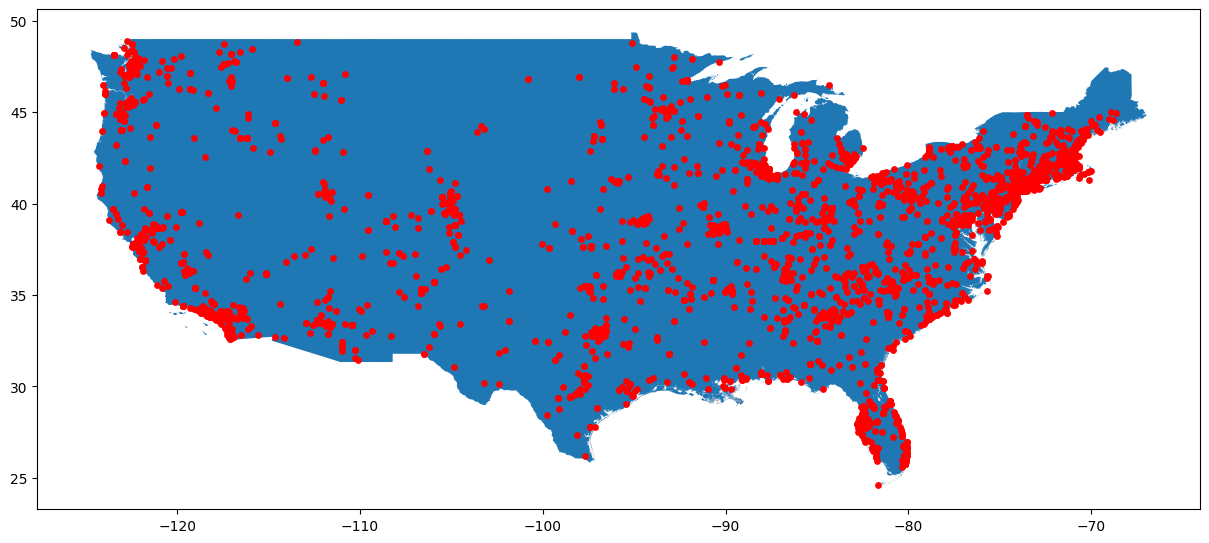

In [90]:
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

# https://datascientyst.com/plot-latitude-longitude-pandas-dataframe-python/

geometry = [Point(c) for c in df.Coords]
gdf = GeoDataFrame(df, geometry=geometry)
gdf.plot(ax=US_body.plot(figsize=(15,15)), marker='o', color='red', markersize=15)
plt.show()

In [91]:
def getFeatures(df):
    shapes = list(df.Shape.unique())
    df[shapes] = pd.get_dummies(df.Shape)
    df = df[['Timestamp', 'Lat', 'Lng', 'Updated_Duration', 'Images'] + shapes]
    df = df.set_index('Timestamp')
    return df

df = getFeatures(df)

In [92]:
df

,Lat,Lng,Updated_Duration,Images,Sphere,Oval,Light,Circle,Other,Triangle,...,Teardrop,Chevron,Formation,Cone,Rectangle,Diamond,Delta,Egg,Cross,Star
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-31 22:00:00,-122.155563,38.053925,60.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2021-07-31 21:30:00,-121.980827,37.550201,1.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2021-07-31 21:15:00,-120.847008,38.682224,15.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-07-31 20:45:00,-76.743195,36.808010,3.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-31 18:30:00,-74.076202,40.643497,0.5,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 09:08:00,-94.578560,39.099792,1.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2022-06-01 04:49:00,-81.656761,30.325968,120.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-06-01 03:40:00,-85.377968,32.650883,0.033333,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
